# Stable Diffusion with Distributed Training and Hosting on Amazon SageMaker

In this notebook, you will learn how you can fine-tune a pretrained [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release) model on SageMaker and deploy it for inference.

Produced by Stability.ai, Stable Diffusion is an open source model available for researchers and the broader ML community. We're pointing to the core content available on Hugging Face [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) and provide private access in the limited context of hands-on workshops. If you'd like longer term access to Stable Diffusion, you'll need to sign up on the Hugging Face Hub, accept the terms, create a token, and download the model and dataset. 

In this lab, we've done that for you already. So let's get started!


This notebook is purely educational for showing how to fine-tune latent-stable-diffusion on Amazon SageMaker. Neither the images produced or code represent Amazon or its views in any way shape or form. To properly leverage this codebase, read the corresponding licenses from [CompVis](https://huggingface.co/spaces/CompVis/stable-diffusion-license) (the model) and [Conceptual Captions](https://huggingface.co/datasets/conceptual_captions) (from Google, but you will use HF)

Model weights were provided by CompVis/stable-diffusion-v1-4. You can find the licensing, README and more [here](https://huggingface.co/CompVis/stable-diffusion-v1-4).  Please note that the finetune.py script has been slightly modified from a PR request [here](https://github.com/huggingface/diffusers/pull/356)

### Step 1. Point to the model and data in S3

First, ask the instructor for the name of the S3 bucket you need to point to.

In [4]:
bucket = " " #please ask your instructor to provide the name of this private bucket 
path = "conceptual_captions"
s3_train_channel = f"s3://{bucket}/{path}"
image_file = '0.jpg'

In [6]:
!aws s3 cp {s3_train_channel}/{image_file} .
!aws s3 cp {s3_train_channel}/dataset.parquet .

download: s3://dist-train/stable-diffusion/conceptual_captions/0.jpg to ./0.jpg
download: s3://dist-train/stable-diffusion/conceptual_captions/dataset.parquet to ./dataset.parquet


In [7]:
import pandas as pd

df = pd.read_parquet('dataset.parquet')

In [8]:
df.head(n=3)

,image_url,caption,sm_key,local_key
0,http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...,a very typical bus station,/opt/ml/input/data/training/0.jpg,0.jpg
1,http://78.media.tumblr.com/3b133294bdc7c7784b7...,sierra looked stunning in this top and this sk...,/opt/ml/input/data/training/1.jpg,1.jpg
2,https://media.gettyimages.com/photos/young-con...,young confused girl standing in front of a war...,/opt/ml/input/data/training/2.jpg,2.jpg


a very typical bus station


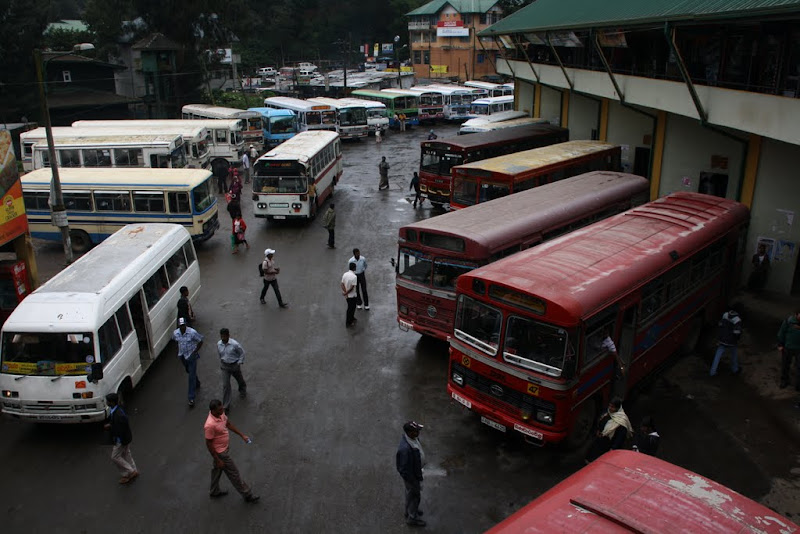

In [9]:
caption = df['caption'][0]
from PIL import Image

print (caption)

Image.open(image_file)

Additionally, the data you will be using comes from mscoco. However, you can also download from [here](https://huggingface.co/datasets/ChristophSchuhmann/MS_COCO_2017_URL_TEXT) which uses the dataset from [here](https://academictorrents.com/details/74dec1dd21ae4994dfd9069f9cb0443eb960c962). Then use this [link](https://github.com/rom1504/img2dataset) to quickly fill in the datasets files. For the purpose of this notebook you can download a few samples using the cell below.

### Step 2. Run distributed training on Amazon SageMaker
Next, let's configure the scripts to run on SageMaker training jobs with high performance GPU's. First, you'll need to determine which instances to use. We'd suggest you start with the `ml.g5.12xlarge`, which has 4 GPUs and is known to work nicely with this training script and dataset.

The training script we're working with today uses Hugging Face's [`accelerate`](https://huggingface.co/docs/accelerate/index) library to run data parallel on all available GPUs. While likely not as performant on AWS as [SageMaker Distributed Data Parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html), it's still an easy and efficient way to run data parallel on SageMaker Training. 

In [10]:
def get_processes_per_host(instance_type):
    if instance_type in ['ml.g5.12xlarge', 'ml.g5.24xlarge', 'ml.p3.8xlarge']:
        processes_per_host = 4
        
    elif instance_type in ['ml.g5.48xlarge', 'ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge']:
        processes_per_host = 8
        
    elif instance_type == 'ml.g4dn.12xlarge':
        print ('Stable diffusion is known to not run nicely on the g4dn.12xlarge, recommend a reset to g5.12xlarge')
    
    else:
        print ('Please look up the number of GPUs per node from the EC2 page here: https://aws.amazon.com/ec2/instance-types/ ')
    
    return processes_per_host

instance_type = 'ml.g5.12xlarge'

processes_per_host = get_processes_per_host(instance_type)

#### Point to an AWS-managed Deep Learning Container
At AWS we provide 70+ prebuilt containers that are battle-tested, and known to run efficiently across SageMaker instances and features.

Available images are listed here: https://github.com/aws/deep-learning-containers/blob/master/available_images.md 

You're welcome to bring your own Dockerfile, and either extend an AWS Deep Learning Container, or simply add the [sagemaker-training toolkit](https://github.com/aws/sagemaker-training-toolkit) to enable remote training job features like script-mode, local mode, distributed training, etc.

In [12]:
image_uri = '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker'

In [14]:
import sagemaker
from sagemaker.huggingface import HuggingFace

def get_estimator(instance_type, processes_per_host):
    
    sess = sagemaker.Session()

    role = sagemaker.get_execution_role()

    est = HuggingFace(entry_point='finetune.py',
                      source_dir='src',
                      image_uri=image_uri,
                      sagemaker_session=sess,
                      role=role,
                      instance_type=instance_type,
                      keep_alive_time_in_seconds = 3600,
                      # output_path = can define s3 output here,
                      py_version='py38',
                      base_job_name='stable-diffusion', 
                      instance_count=1,
                      # all opt/ml paths point to SageMaker training 
                      hyperparameters={
                        'pretrained_model_name_or_path':'/opt/ml/input/data/training/sd-base-model',
                        'dataset_name':'/opt/ml/input/data/training/dataset.parquet',
                        'caption_column':'caption',
                        'image_column':'sm_key',
                        'resolution':256,
                        'mixed_precision':'fp16',
                        'train_batch_size':2,
                        'learning_rate': '1e-10',
                        'max_train_steps':100,
                        'num_train_epochs':1,
                        'output_dir':'/opt/ml/model/sd-output-final',   
                      },    
                      distribution={"mpi":{"enabled":True,"processes_per_host":processes_per_host}})
    return est

est = get_estimator(instance_type, processes_per_host)

#### Enable FastFile Mode to speed up your training job
[`FastFile`](https://aws.amazon.com/about-aws/whats-new/2021/10/amazon-sagemaker-fast-file-mode/) is an option to stream data to your training job, rather than copying from S3. It's great when you don't have more than one million files, but see a bottleneck in the start of your training job. The alternatives are copying from S3, which is slow, or [FSx for Lustre](https://aws.amazon.com/blogs/machine-learning/speed-up-training-on-amazon-sagemaker-using-amazon-efs-or-amazon-fsx-for-lustre-file-systems/), which is the recommend path for very large datasets.

In [15]:
inputs = sagemaker.inputs.TrainingInput(s3_train_channel, s3_data_type='S3Prefix', input_mode='FastFile')

In [16]:
# Please note training can take upwards of 25 minutes (13 minutes for saving the model). 
# only run this cell ONCE!
est.fit(inputs=inputs, wait=False)

### Step 3. Distributed Inference
Next, we'll point to the model we just trained in the previous step and use it to spin up a SageMaker endpoint.

In [19]:
# define from the S3 path if you need to manually point to your model artifact
model_data = 's3://sagemaker-us-east-1-220691188711/stable-diffusion-2022-10-16-13-59-33-347/output/model.tar.gz'

In [20]:
from sagemaker.huggingface import HuggingFaceModel
import sagemaker

role = sagemaker.get_execution_role()

sess = sagemaker.Session()

# hard code point to an image we're hosting for this workshop
image_uri = '911195073761.dkr.ecr.us-east-1.amazonaws.com/sd-inference-gpu:latest'

est=HuggingFaceModel(role=role,
                     py_version='py38',
                     model_data=model_data,
                     image_uri=image_uri,
                     sagemaker_session= sess,
                     # set this to the number of GPUs in the intance type you'd like to use
                     model_server_workers= 4
)

Deploy your model for inference!

In [22]:
pred = est.deploy(instance_type='ml.g5.12xlarge',
                  initial_instance_count=1)

----------!

Provide prompts for training. The first text argument is based on this current dataset.

In [23]:
prompts = [caption,'A photo of an astronaut riding a horse on mars', 
           'A dragonfruit wearing karate belt in the snow.', 
           'Teddy bear swimming at the Olympics 400m Butter-fly event.',
           'A cute sloth holding a small glowing treasure chest.']

For more parameters feel free to explore [here](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion), just add 'parameters':{'key':'value'} to the input dict.

In [24]:
outputs = [pred.predict({'inputs':prompt}) \
           for prompt in prompts]

In [25]:
outputs = [output['images'][0] for output in outputs]

In [26]:
from PIL import Image
from io import BytesIO
import base64

def process_result(out):
    return Image.open(BytesIO(base64.b64decode(out)))

In [27]:
images = [[process_result(output),prompt] for output,prompt in zip(outputs,prompts)]

#### Visualize the results from the inference

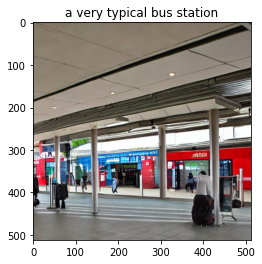

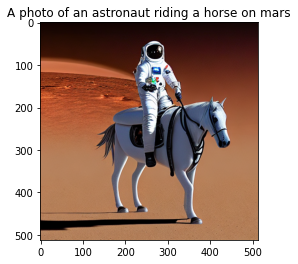

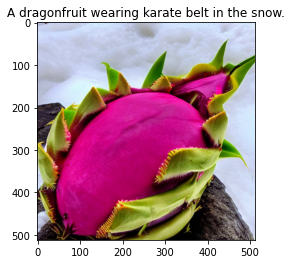

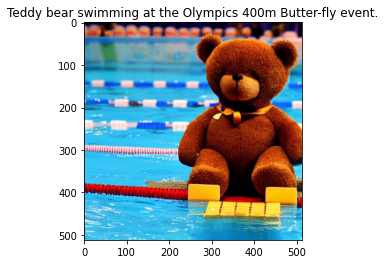

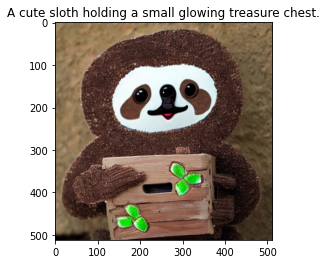

In [28]:
import matplotlib.pyplot as plt

for i in range(len(images)):
    plt.figure()
    plt.title(images[i][1])
    plt.imshow(images[i][0])

#### Generate images from text
Now let's test the results line by line!

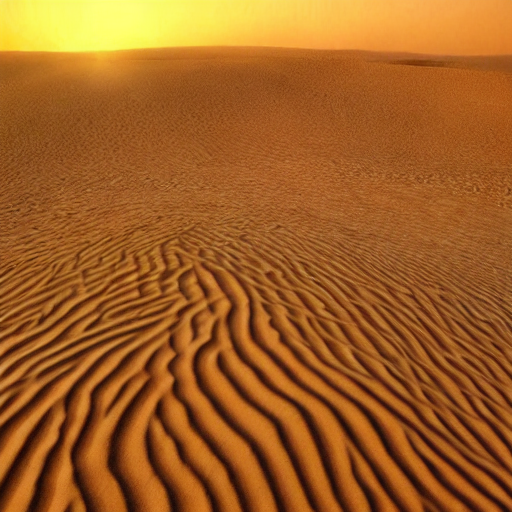

In [39]:
prompt = "a beautiful hot arabian desert"

output = pred.predict({'inputs':prompt})
process_result(output['images'][0])

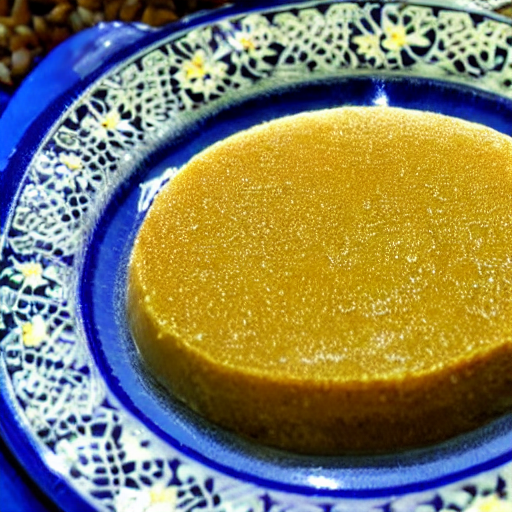

In [41]:
prompt = "a delicious arabian dessert"

output = pred.predict({'inputs':prompt})
process_result(output['images'][0])

In [ ]:
# clean up your endpoint
# pred.delete_endpoint()